# pyCTF

pyCTF package allows to measure lens aberrations from experimental contrast transfer functions (CTFs). It contains functionality for: 

- Simulating CTFs

The following lens aberrations can be measured:
- Defocus
- Twofold astigmatism
- Spherical aberration
- Chromatic aberration

First, import the package and dependancies:

In [1]:
import pyCTF
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

invoking __init__.py for pyCTF


## Simulating contrast transfer functions

### 1D CTF simulation

A CTF can be simulated in 1D using the CTFSimulation1D class:

In [ ]:
from pyCTF.simulation import CTFSimulation1D

CTF = CTFSimulation1D( 5.0, int(2000), 200, -251.5 )
CTF.plot_ctf()
CTF.print_aberrations()

By changing the class attributes and calling the update function, the simulation can be updated:

In [ ]:
CTF.Cs = 1.68e-3
CTF.defocus = -300e-9
CTF.update()
CTF.plot_ctf()
CTF.print_aberrations()

We can also view each simulated function individually:

In [ ]:
CTF.show_all()

### 2D CTF simulation

The same process can be used to simulate a CTF in 2D:

In [ ]:
from pyCTF.simulation import CTFSimulation2D
image_size = int(256) #pixels
acc_voltage = 200 #kV
max_frequency = 5 #nm-1
defocus = -300 #nm

CTF2D = CTFSimulation2D( max_frequency, image_size, acc_voltage, defocus)
CTF2D.plot_ctf()

It can be updated in the same way:

In [ ]:
CTF2D.C12a = 75e-9 #m
CTF2D.C12b = 10e-9 #m
CTF2D.phi = np.deg2rad(110)
CTF2D.update()
CTF2D.print_aberrations()

CTF2D.show_all()

## Measuring lens aberrations

### Defocus and spherical aberration

Defocus is measured by extracting and fitting the minima of the CTF (a.k.a. "zeros"). Based on the Based on the method of Krivanek (Krivanek, 1976) developed by Coene (Coene, 1991) and the description given in Zou et al (Zou et al, 2011).

The spatial frequency of each minima ($k_0$) is extracted, then the following equation is used to plot a straight line: 

$ \frac{n}{k_0^2}  = \frac{Cs\lambda^2}{2} k + \epsilon $

The defocus is given by the y-intercept ($\epsilon$), and the gradient can be rearranged to give the spherical aberration of the objective lens.

First, import an image as a CTF object:

Error: could not add scalebar to image.


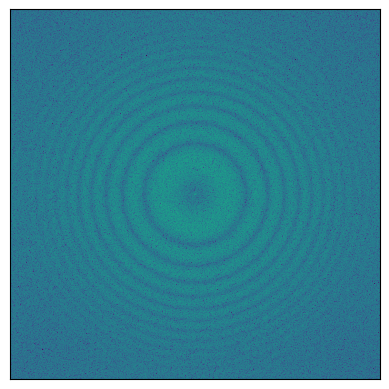

In [6]:
from pyCTF.CTF_image import CTFImage
from pyCTF.misc import show_image

CTF = pyCTF.CTF_image.import_ctf( np.array( Image.open( 'assets\\example_CTF.tif' )), 
											200, 
											0.0066127 )

show_image( CTF.image, scale=CTF.scale )

This example is of an ultrathin carbon film, recorded on a field-emisson gun TEM at 200 kV.
Next we will remove the background from the CTF using Fourer space methods (Barthel et al, 2010). This removes the low-frequency background, and the high-frequency envelope:

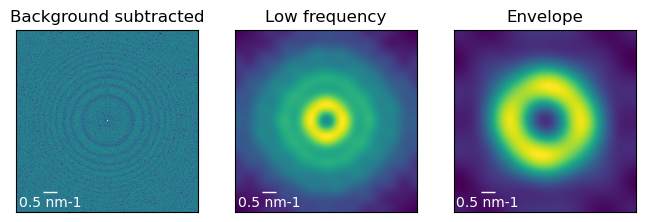

In [7]:
CTF.remove_background( 8, 4 )
CTF.plot_background()

Then, convert the CTF to 1D by taking it's radial profile. The radial profile is then cropped to the supplied frequency range, the baseline is subtracted, and Savitsky-Golay smoothing is applied. 

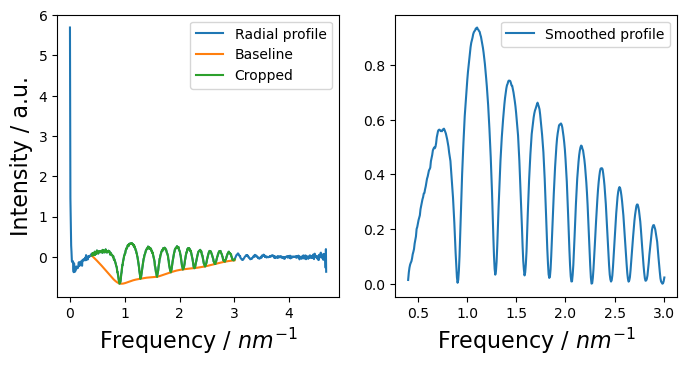

In [9]:
CTF.process_CTF_profile( f_limits=[0.4,3.0], polynomial=10, window=3 )
CTF.plot_radial_profiles()

Finally, we use lmfit to find the Cs and defocus. A figure is created showing the fit, and the results are printed to console (controlled via 'verbose' kwarg):

-------------
lmfit results
-------------
[[Model]]
    Model(gradient_simple)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 50
    # data points      = 10
    # variables        = 2
    chi-square         = 1.0071e-04
    reduced chi-square = 1.2588e-05
    Akaike info crit   = -111.058800
    Bayesian info crit = -110.453630
    R-squared          = 0.99663588
[[Variables]]
    m:  0.02118092 +/- 4.3508e-04 (2.05%) (init = -1)
    c: -2.43240134 +/- 0.00236267 (0.10%) (init = 0)


---------------
Fitting results
---------------
Defocus (nm): -484.9412503734127
Spherical aberration (mm): 1.3427539757749367
----------------------
Radial profile
----------------------
Maximum frequency (nm-1): 3.30635
Fitted range x (nm-1): 0.4 - 3.0
Fitted range y:-1.0 - 1.0
------------------------
Savitksy-Golay smoothing
------------------------
Polynomial=15
Window=3
---------------
Detected minima
---------------
|------------------|-------|
| Frequency (nm-1) | Inde

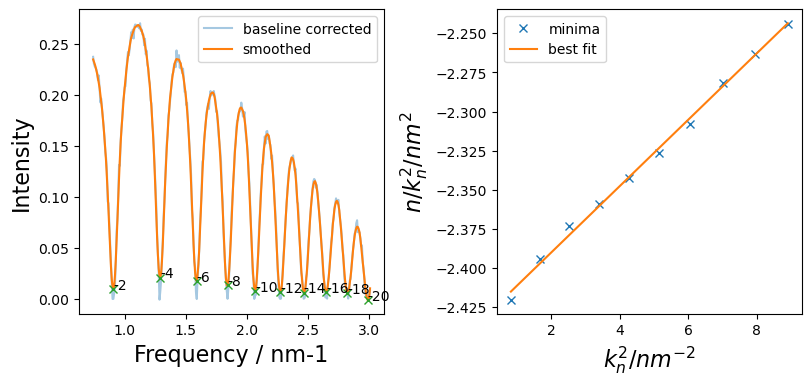

In [15]:
CTF.remove_background( 8, 4 )
CTF.measure_defocus( polynomial=15,# Polynomial for Savitsky-Golay smoothing.
                     window=3,# Window size for Savitsky-Golay smoothing.
                     f_limits=[0.75,3.0],# Range of freqeuncy to fit.
                     underfocus=True,# False for overfocus.
                     xlim=[0.4,3.0],# Exclude all minima outside this range.
                     start=2 )# First index for fitting.
CTF.print_Cs_results( verbose=True )

### Chromatic aberration

Chromatic aberration ($C_c$) can be measured using the following relationship (Klemperer, 1971): 

$ \Delta F = C_c ( \frac{\Delta V}{ V} -  \frac{2*\Delta I}{ I }  )$

Where $I$ is the objective lens current, $V$ is the accelerating voltage, $\Delta V$ is the voltage instability, and $\Delta F$ is the change in lens focal length. Assuming the objective lens current instability ($\Delta I$) is negligable, measuring the change in defocus as a function of the accelerating voltage gives the chromatic aberration of the objective lens via (McMullan et al, 2023):

$ \Delta F = C_c \Delta V$

We can do this with a linear fit. First, declare the defocus and their accelerating voltages:

In [ ]:
voltage = 200
voltage_data = np.array([200.0, 199.95, 199.90, 199.85, 199.80, 199.75, 199.70])
defocus_data =   np.array([ -714.09, -433.04, -197.66, 0, 240.20, 458.89, 688.94 ])*1e-9

Then, fit the data:

In [ ]:
from pyCTF.chromatic_aberration import chromaticAberration
Cc = chromaticAberration( voltage, voltage_data, defocus_data)
fit_method = 'lmfit'
Cc.fit( method=fit_method )
Cc.plot_figure( method=fit_method )
Cc.print_results( method=fit_method )
plt.show()

### Measuring objective lens twofold astigmatism

Even when corrected by the operator, small amounts of twofold astigmatism in the objective lens are common.

Twofold astigmatism consists of an angle and a magnitude. The angle is measured from the cross-correlation of the CTF with it's mirror-image (cite: CTFFind 4). We will use the CTFImage class and the twofoldAstigmatism class.

First, import the CTF as a CTF object and remove the background:

In [ ]:
CTF = pyCTF.CTF_image.import_ctf( np.array( Image.open( 'assets\\example_CTF.tif' )), 
											200, 
											0.0066127 )
CTF.remove_background(10, 10)
show_image( CTF.image, scale=CTF.scale )

Next, we find the angle og astigmatism using the method of *name* (citation). The CTF is converted to polar coordinates, then cross-correlated with it's mirror image to find it's maximum angular variation:

In [ ]:
CTF.astig_angle()
CTF.astig.plot_angles()

Then, we measure the magnitude of astigmatism, using the method of *name* (citation). We cross-correlate the experimental CTF with simulated CTFs, generating a heatmap of likely astigmatism distances:

In [ ]:
CTF.astig_magnitude( -1000,
                     slices=20,
                     max_val=100 )

## Compositing images

We can simulate a CTF and overlay it on an experimental CTF. By default the simulated CTF is displayed on the bottom right corner of the new image.

Error: could not add scalebar to image.


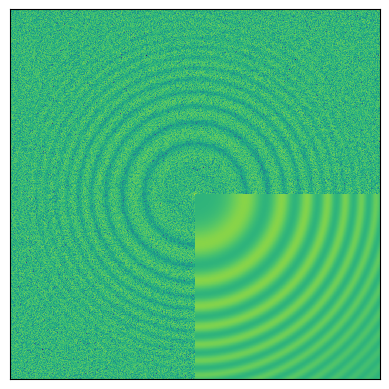

In [29]:
CTF = pyCTF.CTF_image.import_ctf( np.array( Image.open( 'assets\\example_CTF.tif' )), 
											200, 
											0.0066127 )
CTF.remove_background(10, 10)

from pyCTF.misc import composite_image, show_image
from pyCTF.simulation import CTFSimulation2D
image_size = CTF.width #pixels
acc_voltage = 200 #kV
max_frequency = CTF.max_freq_inscribed #nm-1
defocus = -1000 #nm
simCTF = CTFSimulation2D( max_frequency, image_size, acc_voltage, defocus)

simCTF.Cs=1.3e-3
simCTF.update()

composite = composite_image( CTF.image,# Base image.
                 simCTF.square_CTF,# Image to overlay.
                 int(CTF.width/2) )# Size of output.

show_image( composite, scale=CTF.scale )

## Manipulating Fourier transforms

### 2D Fourier transform of CTF
pyCTF's Fourier class uses Numpy to perform fast Fourier transforms (FFTs). It can be used to convert a suitable image into a CTF. 

Here, the image is imported and an FFT is performed. The DC freqeuncies are shifted to the middle. The full-sized FFT is then cropped to 300 by 300 pixels to reveal the CTF:

In [ ]:
from pyCTF.fourier import Fourier
image =  np.array( Image.open( 'assets//UTC_TF_stack.tif' ))
FFT = Fourier.imfft( image )
FFT = Fourier.crop( FFT, 300 )
FFT = Fourier.log_mod( FFT )

show_image( FFT, scale=0.14782, length=2 )

FFTs can be performed on each slice in an image stack, for example for a through-focus series:

In [ ]:
from pyCTF.fourier import Fourier
stack = Fourier.import_stack( 'assets//UTC_TF_stack.tif' )
FFT, prof = Fourier.through_focus( stack, width=350 )
plt.matshow(prof)

### 3D Fourier transform of CTF
In some cases it is useful to perform a 3D FFT of a stack:

In [ ]:
## examples of Fourier class 3D
from pyCTF.fourier import Fourier

stack = Fourier.import_stack( 'assets//UTC_TF_stack.tif' )

FFT3D = Fourier.fft3d( stack )
FFT3D = np.log(np.abs(FFT3D))
img = np.rot90( FFT3D, k=1, axes=(0, 2) )
img = np.sum( img[:,:,:], 2 )
output, filtered = Fourier.measure_arcs( img, 4 )
Fourier.plot_arcs( filtered, output )